## kNN classifiers

### Imports and global variables

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

import imp
plotter = imp.load_source('plotter', '/Users/katbishop/Desktop/DSI-SF2-bishopkd/utils/plotting/knn_plotter.py')
from sklearn.metrics import roc_curve, auc
from plotter import KNNBoundaryPlotter
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

plt.style.use('fivethirtyeight')
%matplotlib inline

path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'

#### Load the data

In [74]:
# load training data
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']
#del df['Unnamed: 0.1']

# load held-out testing data
df_test = pd.read_csv(path + 'df_test.csv')
del df_test['Unnamed: 0']

df_all = pd.concat([df,df_test], axis=0).reset_index()
del df_all['index']

print df.shape
print df_test.shape
print df_all.shape
df_all.head(2)

(78, 64)
(14, 64)
(92, 64)


,adj,adj_compare,adj_sup,adv,adv_compare,adv_part,adv_sup,avg_sent_len,avg_word_len,best_seller,...,verb_count,verb_ger,verb_past,verb_pp,verb_sing_pres,wh_adv,wh_determ,wh_poss,wh_pronoun,word_count
0,0.069588,0.003314,0.002129,0.063591,0.001534,0.006965,0.000265,14,4,1,...,29612.0,0.023553,0.070598,0.023559,0.019427,0.005545,0.004228,0.000024,0.004685,166265
1,0.065146,0.004336,0.003233,0.067069,0.002154,0.005526,0.000405,11,4,1,...,36339.0,0.019928,0.078151,0.024544,0.015360,0.004794,0.003826,0.000043,0.004250,207548


In [75]:
# subset the data
sf = df_all[df_all['sci_fi']==1]
rm = df_all[df_all['sci_fi']==0]
print sf.shape
print rm.shape

(47, 64)
(45, 64)


#### Science-fiction

In [81]:
y_sf = sf['best_seller'].values
#X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane']].values
X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']].values
print y_sf.shape, X_sf.shape

X_sf, X_sf_test, y_sf, y_sf_test = train_test_split(X_sf, y_sf, test_size=0.3)

print X_sf.shape, y_sf.shape
print X_sf_test.shape, y_sf_test.shape

(47,) (47, 54)
(32, 54) (32,)
(15, 54) (15,)


In [79]:
def accuracy_crossvalidator(X, y, knn, cv_indices):
    scores = []
    for train_i, test_i in cv_indices:
        
        X_train = X[train_i, :]
        X_test = X[test_i, :]
        y_train = y[train_i]
        y_test = y[test_i]

        knn.fit(X_train, y_train)
        acc = knn.score(X_test, y_test)
        scores.append(acc)
        
        print('Fold accuracy:', acc)    
    print('Mean CV accuracy:', np.mean(scores))

In [82]:
cv = StratifiedKFold(y_sf, n_folds=10)
knn_sf = KNeighborsClassifier(n_neighbors=3, weights='distance')
accuracy_crossvalidator(X_sf, y_sf, knn_sf, cv)

('Fold accuracy:', 1.0)
('Fold accuracy:', 0.5)
('Fold accuracy:', 0.75)
('Fold accuracy:', 0.75)
('Fold accuracy:', 0.25)
('Fold accuracy:', 0.66666666666666663)
('Fold accuracy:', 1.0)
('Fold accuracy:', 1.0)
('Fold accuracy:', 0.0)
('Fold accuracy:', 0.5)
('Mean CV accuracy:', 0.64166666666666661)


In [87]:
search_parameters = {
    'n_neighbors': range(1,12), 
    'weights':      ['uniform','distance']
}

knn = KNeighborsClassifier() 
knn_gs = GridSearchCV(knn, search_parameters, cv=10, verbose=1)

knn_sf = knn_gs.fit(X_sf, y_sf)
knn_proba_sf = knn_sf.predict_proba(X_sf_test)

print knn_sf.best_params_
best_knn_sf = knn_sf.best_estimator_
print best_knn_sf
accuracy_crossvalidator(X_sf, y_sf, best_knn_sf, cv)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s


{'n_neighbors': 3, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
('Fold accuracy:', 1.0)
('Fold accuracy:', 0.5)
('Fold accuracy:', 0.5)
('Fold accuracy:', 0.75)
('Fold accuracy:', 0.25)
('Fold accuracy:', 1.0)
('Fold accuracy:', 1.0)
('Fold accuracy:', 1.0)
('Fold accuracy:', 0.5)
('Fold accuracy:', 0.5)
('Mean CV accuracy:', 0.69999999999999996)


[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.6s finished


In [107]:
#plot_roc_curve(target=y_sf_test, predict_proba=knn_proba_sf[:,1], title='Science-fiction best-seller prediction')

#### Romance

In [98]:
y_rm = rm['best_seller'].values
X_rm = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']].values

print  X_rm.shape,y_rm.shape

X_rm, X_rm_test, y_rm, y_rm_test = train_test_split(X_rm, y_rm, test_size=0.3)

print X_rm.shape, y_rm.shape
print X_rm_test.shape, y_rm_test.shape

(45, 54) (45,)
(31, 54) (31,)
(14, 54) (14,)


In [99]:
cv_rm = StratifiedKFold(y_rm, n_folds=10)
knn_rm = KNeighborsClassifier(n_neighbors=3, weights='uniform')
accuracy_crossvalidator(X_rm, y_rm, knn_rm, cv_rm)

('Fold accuracy:', 0.75)
('Fold accuracy:', 0.75)
('Fold accuracy:', 1.0)
('Fold accuracy:', 0.33333333333333331)
('Fold accuracy:', 1.0)
('Fold accuracy:', 1.0)
('Fold accuracy:', 0.66666666666666663)
('Fold accuracy:', 0.33333333333333331)
('Fold accuracy:', 0.66666666666666663)
('Fold accuracy:', 1.0)
('Mean CV accuracy:', 0.75)


In [101]:
search_parameters = {
    'n_neighbors': range(1,12), 
    'weights':      ['uniform','distance']
}

knn_rm = KNeighborsClassifier() 
knn_rm_gs = GridSearchCV(knn_rm, search_parameters, cv=10, verbose=1)

knn_rm = knn_rm_gs.fit(X_rm, y_rm)
knn_proba_rm = knn_rm.predict_proba(X_rm_test)

print knn_rm_gs.best_params_
best_knn_rm = knn_rm_gs.best_estimator_
print best_knn_rm
accuracy_crossvalidator(X_rm, y_rm, best_knn_rm, cv_rm)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s


{'n_neighbors': 3, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
('Fold accuracy:', 0.75)
('Fold accuracy:', 0.75)
('Fold accuracy:', 1.0)
('Fold accuracy:', 0.33333333333333331)
('Fold accuracy:', 1.0)
('Fold accuracy:', 1.0)
('Fold accuracy:', 0.66666666666666663)
('Fold accuracy:', 0.33333333333333331)
('Fold accuracy:', 0.66666666666666663)
('Fold accuracy:', 1.0)
('Mean CV accuracy:', 0.75)


[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.6s finished


In [108]:
#plot_roc_curve(target=y_rm_test, predict_proba=knn_proba_rm[:,1], title='Romance best-seller prediction')

In [1]:
# add confusion matrix plot
# roc curve and other auroc

#### All together now

In [109]:
y = df['best_seller'].values
X = df[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']].values

print y.shape, X.shape

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3)

print X.shape, y.shape
print X_test.shape, y_test.shape


(78,) (78, 54)
(54, 54) (54,)
(24, 54) (24,)


In [114]:
cv_all = StratifiedKFold(y, n_folds=10)
search_parameters = {
    'n_neighbors': range(1,12), 
    'weights':      ['uniform','distance']
}

knn = KNeighborsClassifier() 
knn_gs = GridSearchCV(knn, search_parameters, cv=10, verbose=1)

knn_all = knn_gs.fit(X, y)
knn_proba_all = knn_all.predict_proba(X_test)
print knn_gs.best_params_
best_knn = knn_gs.best_estimator_
print best_knn
accuracy_crossvalidator(X, y, best_knn, cv_all)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s


{'n_neighbors': 3, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
('Fold accuracy:', 0.5)
('Fold accuracy:', 0.5)
('Fold accuracy:', 0.66666666666666663)
('Fold accuracy:', 0.83333333333333337)
('Fold accuracy:', 0.66666666666666663)
('Fold accuracy:', 0.5)
('Fold accuracy:', 0.59999999999999998)
('Fold accuracy:', 0.80000000000000004)
('Fold accuracy:', 0.0)
('Fold accuracy:', 1.0)
('Mean CV accuracy:', 0.60666666666666669)


[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.7s finished


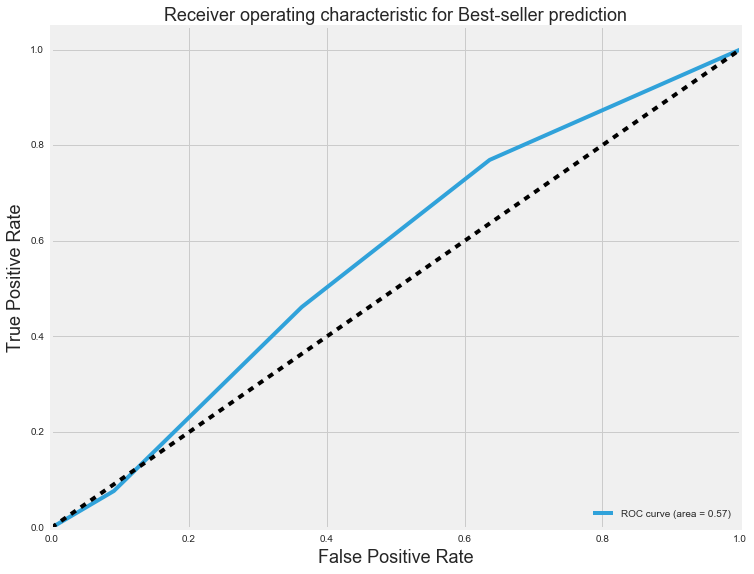

In [115]:
plot_roc_curve(target=y_test, predict_proba=knn_proba_all[:,1], title='Best-seller prediction')

In [118]:
# from pattern.en     import tag
# from pattern.vector import KNN, count

# knn = KNN()

# for i in range(0,len(df_all)):
#     for text in df_all.ix[i,'body']:
#         s = tweet.text.lower()
#         p = '#win' in s and 'WIN' or 'FAIL'
#         v = tag(s)
#         v = [word for word, pos in v if pos == 'JJ'] # JJ = adjective
#         v = count(v) # {'sweet': 1}
#         if v:
#             knn.train(v, type=p)

# print knn.classify('sweet potato burger')
# print knn.classify('stupid autocorrect')

In [89]:
def plot_roc_curve(target=False, predict_proba=False, title='Your prediction'):

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    FPR[1], TPR[1], _ = roc_curve(target,predict_proba)
    ROC_AUC[1] = auc(FPR[1], TPR[1])

    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for %s' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()